# Majority of this code is extracetd from the notebook "BraTS22.ipynb" on the OptiNet Gitbub

**NOTE:**

All file paths are set up for running on Windows.

Change the double backward slashes (\ \ ) to a forward slash (/) for files on Linux or MacOS systems

# Setup

### Necessary Imports

In [1]:
import sys 
# sys.path.append('/Users/XXXX/Desktop/Workspace/Projects/UNN_BraTS23/scripts')
sys.path.append('C:\\Users\\XXXX\\Documents\\SPARK\\BraTS2023\\UNN_BraTS23\\scripts')
import subprocess
try:
    import os
    import numpy as np 
    import matplotlib.pyplot as plt
    import torch
    import torchio as tio
    import nibabel as nib
    from glob import glob
    from subprocess import call
    from scipy.ndimage import label
    from monai.inferers import sliding_window_inference
except ModuleNotFoundError as e:
    package = str(e).split("'")[0]
    subprocess.run(['pip', 'install', package])

### Define Funcetions

In [2]:
# Save to nifti
def save_nifti(final_np, img, outfile):
    '''
    Save numpy to NIfTI format
    input numpy must have 3 dimensions only
    '''
    
    img = nib.load(img) ## load original image from path
    nib.save(
        nib.Nifti1Image(final_np, img.affine, header=img.header),
        outfile
    )

def save_final_preds(pred, img, outfile, fname):
    #convert tensor to tio subject for padding and affine alignment
    predT = torch.from_numpy(pred).unsqueeze(0)
    subject = tio.Subject(
            image=tio.ScalarImage(tensor=predT),
            name=fname
            )
    tranformed_subject = tio.CropOrPad((240, 240, 155))
    tranformed_subject = tranformed_subject(subject)
    pred_final = tranformed_subject["image"].data.numpy().squeeze(0)
    print(f"Shape chanes: initial = {pred.shape}, tensor = {predT.shape}, and final npy = {pred_final.shape}")

    save_nifti(pred_final, img, outfile)


#------------ OPTINET -----##
def to_lbl(pred):
    print("in to_lbl: ", pred.shape)
    print(pred.shape)
    print(pred[0].shape, pred[1].shape, pred[2].shape)
    # labels_dict = {"0": "background", "1": "edema", "2": "non-enhancing tumor", "3": "enhancing tumour"}

    # # The segementation volume contains values [0, 1, 2, 3]. As per BraTS summarizing paper for 2023, annotations comprise the 
    # - 1 for NCR (necrotic tumor core)
    # - 2 for ED (peritumoral edematous/invaded tissue)
    # - 3 for ET (GD-enhancing tumor)
    # - 0 for everything else

    enh = pred[2]
    print(enh.shape)
    pad = pred == 0.5
    pred[pad==True] = 0

    c1, c2, c3 = pred[0] > 0.4, pred[1] > 0.35, pred[2] > 0.375
    print("CShapes: ", c1.shape, c2.shape, c3.shape)
    # print(set(pred.flatten()))
    print("before assignment:" ,pred.shape)

    # print(set(pred.flatten()))
    pred = (c1 > 0).astype(np.uint8)
    # print(set(pred.flatten()))
        #  assigns 0 to elements in pred where c1 is False and 1 where c1 is True, effectively converting c1 to 0s and 1s in pred
            ## if the WT probability for a given voxel is less than 0.45 then its class is set to 0 (background) or its assigned to NCR

    pred[(c2 == False) * (c1 == True)] = 2 
    # print(set(pred.flatten()))
        # This step assigns 2 to regions where c2 is False and c1 is True, which might indicate a region that extends beyond the threshold of c1 and is within the threshold of c2.
            # otherwise if the probability for TC is less than 0.4 the voxel class is 2 (ED) (wherever NCR was assigned in C1 as 1, if TC is false at that point, then class is oedema)

    pred[(c3 == True) * (c1 == True)] = 3
    # print(set(pred.flatten()))
        # assigns 3 to regions where c3 is True and c1 is True, which might indicate a region that is within the threshold of both c1 and c3.
        # finally if probability for ET is less than 0.4 voxel has class 1 (NCR), or otherwise 4 (ET).

    print("after assignment: ", pred.shape)


    components, n = label(pred == 3)
    for et_idx in range(1, n + 1):
        _, counts = np.unique(pred[components == et_idx], return_counts=True)
        if 1 < counts[0] and counts[0] < 4 and np.mean(enh[components == et_idx]) < 0.9:
            pred[components == et_idx] = 1
    print("after for loop: ", pred.shape)
    
    et = pred == 3
    if 0 < et.sum() and et.sum() < 5 and np.mean(enh[et]) < 0.9:
        pred[et] = 1
    print("before _lbl return: ", pred.shape)

    pred = np.transpose(pred, (2, 1, 0)).astype(np.uint8)
    print("after transpose: ", pred.shape)
    return pred

def prepare_preditions(e):
    
    # CALL BELOW LINE FOR POST PROCESSING with multiple folds
    preds = [np.load(f) for f in e]
    p = to_lbl(np.mean(preds, 0))

    # ELSE JUST LOAD THE NPY FILE
    # preds = np.load(e)
    # print(preds.shape)

    # p = to_lbl(preds)
    print(p.shape)

    return p

# Post-Processing npy Predictions

In [ ]:
#--------------PATH TO VOLUMES
# examples = sorted(glob('C:\\Users\\XXXX\\Documents\\SPARK\\BraTS2023\\results\\npy\\*'))
# orig_data = 'C:\\Users\\XXXX\\Documents\\SPARK\\BraTS2023\\Data\\SSA_Val'
# orig_data = 'C:\\Users\\XXXX\\Documents\\SPARK\\BraTS2023\\Data\\val_SSA\\monai'
orig_data = 'D:\\CourseStuff\\SPARK\\BraTS2023\\CC\\val_SSA\\monai'
print(os.path.exists(orig_data))

#------------- OPTINET     
# preds = sorted(glob('C:\\Users\\XXXX\\Documents\\SPARK\\BraTS2023\\results\\train_gli\\ftSSA_f0\\predictions*'))
preds = sorted(glob('D:\\CourseStuff\\SPARK\\BraTS2023\\results\\train_gli\\ftSSA\\predictions\\predictions*'))


# -------------PATH TO SAVE NiFTI FILES
results = 'D:\\CourseStuff\\SPARK\\BraTS2023\\results\\' #### CHANGE TO REFLECT YOUR FOLDER STRUCTURE
final_preds = os.path.join(results, "final_preds")
try:
    os.makedirs(f"{final_preds})
except:
    print("directory exists")

## ----------------- USE IF MULTIPLE FOLDS HAVE PRODUCED PREDICTIONS
examples = list(zip(*[sorted(glob(f"{p}\\*.npy")) for p in preds]))
print(examples)
print("Preparing final predictions")
for e in examples:
    pred = prepare_preditions(e)
    fname = e[0].split("\\")[-1].split(".")[0]
    outfile = os.path.join(results,"final_predsftSSA_5folds", f"{fname}.nii.gz")
    img = os.path.join(orig_data, fname, f"{fname}-t1n.nii.gz")
    img_load = nib.load(img)
    nib.save(
        nib.Nifti1Image(pred,img_load.affine, header=img_load.header),outfile)
print("Finished!")

## ----------------- USE IF ONLY ONE FOLD HAS PRODUCED PREDICTIONS
# examples = [sorted(glob(f"{p}\\*.npy")) for p in preds]
# print(examples)
# print("Preparing final predictions")
# for e in examples:
#     print(e)
#     for pnpy in e:
#         pred = prepare_preditions(pnpy)
#         fname = pnpy.split("\\")[-1].split(".")[0]
#         # print(pred.shape)
#         outfile = os.path.join(results,"final_predsEpoch75", f"{fname}.nii.gz")
#         img = os.path.join(orig_data, fname, f"{fname}-t1n.nii.gz")
#         img_load = nib.load(img)
#         nib.save(
#             nib.Nifti1Image(pred, img_load.affine, header=img_load.header),
#         outfile)
    
print("Completed!")

In [ ]:
lbl_chk = np.load('C:\\Users\\XXXX\\Documents\\SPARK\\BraTS2023\\results\\preds_allFolds\\predictions_epoch=128-dice=93_74_task=01_fold=3_tta\\BraTS-SSA-00143-000.npy')

print("Brain background: ", lbl_chk[:,70,89,76])
print("pad background: ",lbl_chk[:,70,227,216] )
print("Yellow: ",lbl_chk[:,70,113,178])
print("Green: ",lbl_chk[:,70,134,150])
print("Red: ",lbl_chk[:,70,142,121])


BraTS-SSA-00126-000
BraTS-SSA-00129-000
BraTS-SSA-00132-000
BraTS-SSA-00139-000
BraTS-SSA-00143-000
BraTS-SSA-00148-000
BraTS-SSA-00158-000
BraTS-SSA-00169-000
BraTS-SSA-00180-000
BraTS-SSA-00188-000
BraTS-SSA-00192-000
BraTS-SSA-00198-000
BraTS-SSA-00210-000
BraTS-SSA-00218-000
BraTS-SSA-00227-000


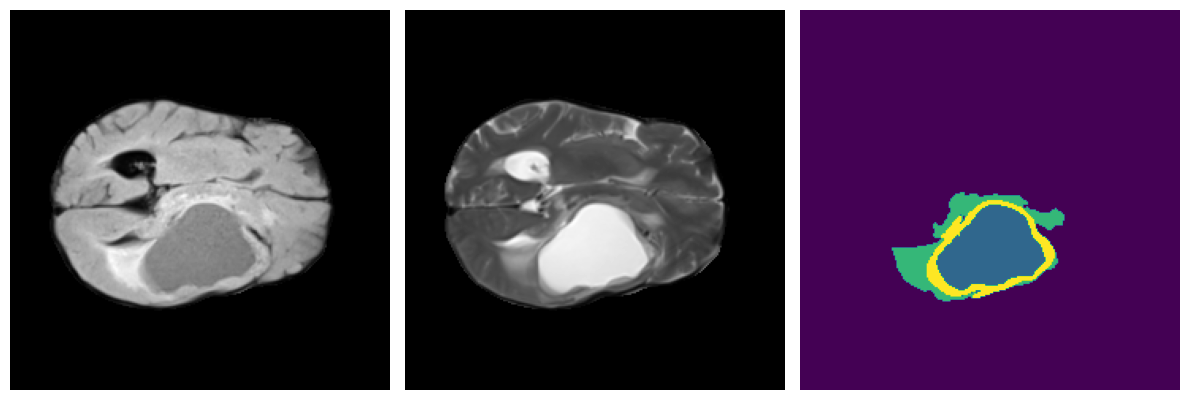

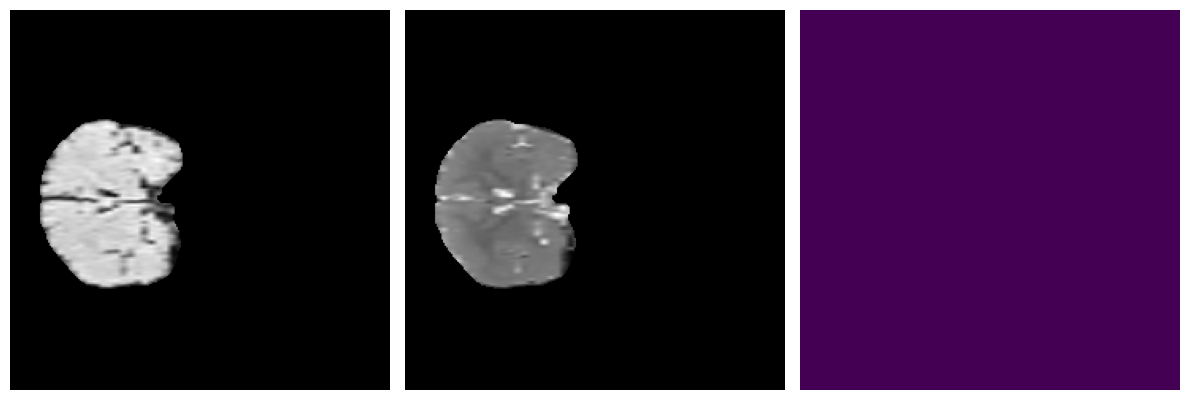

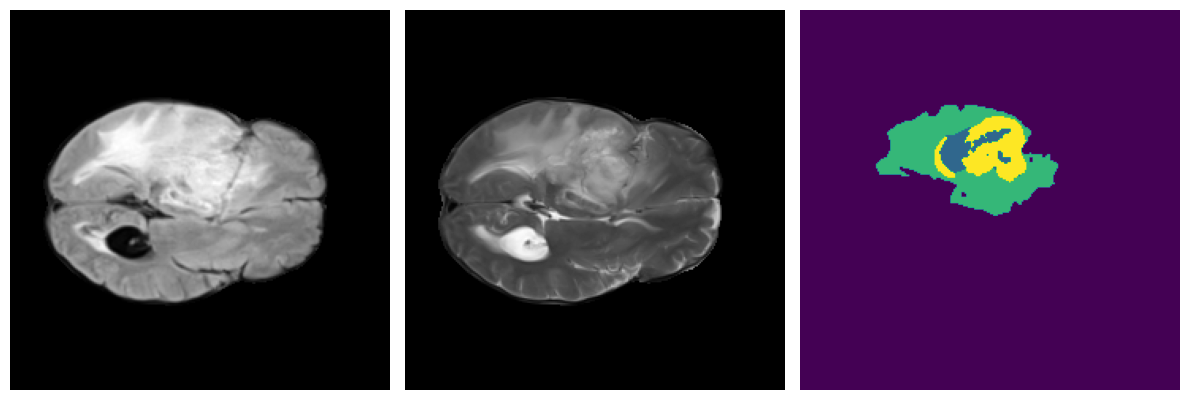

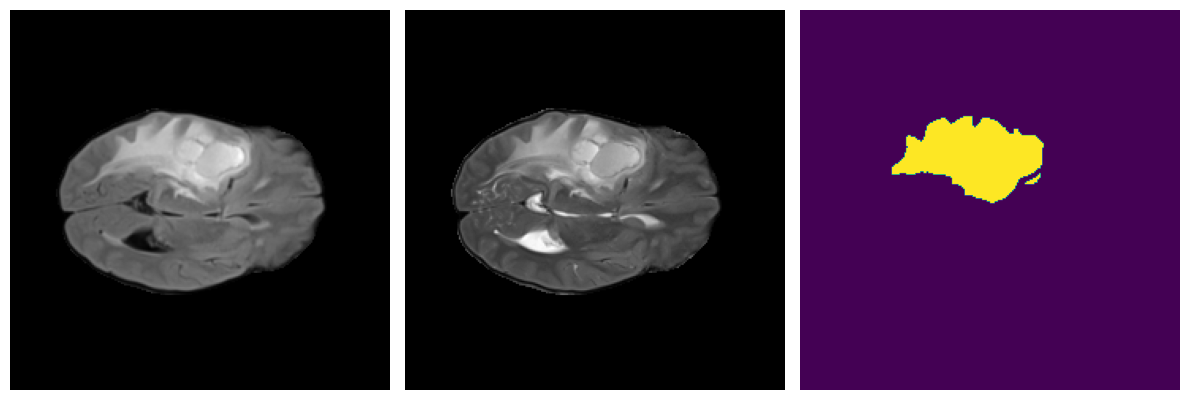

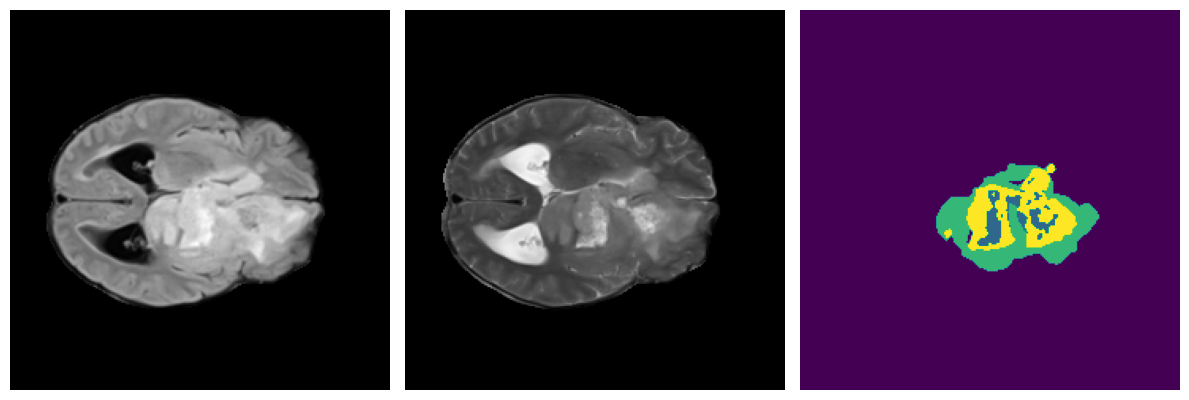

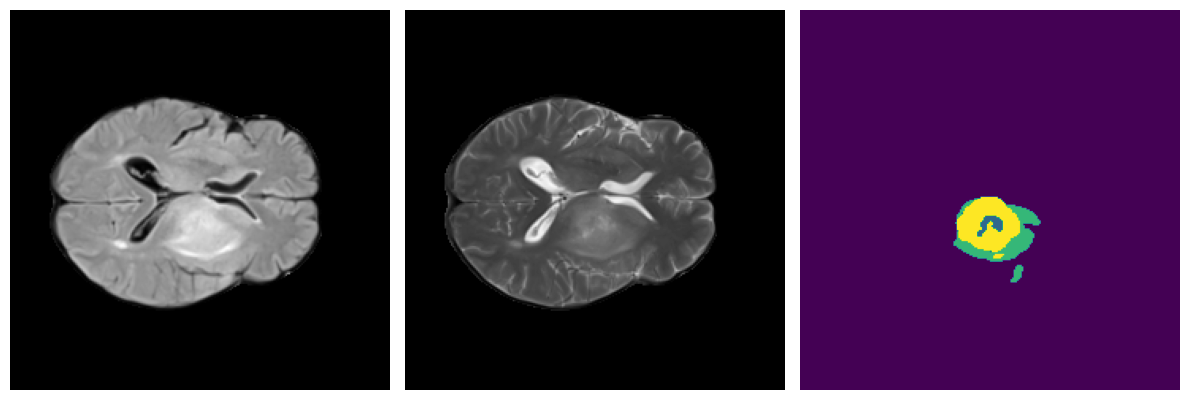

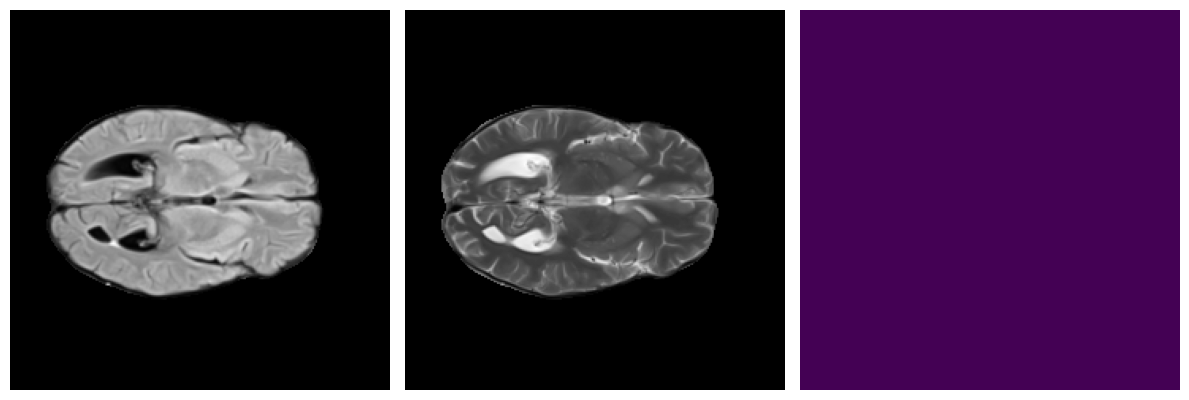

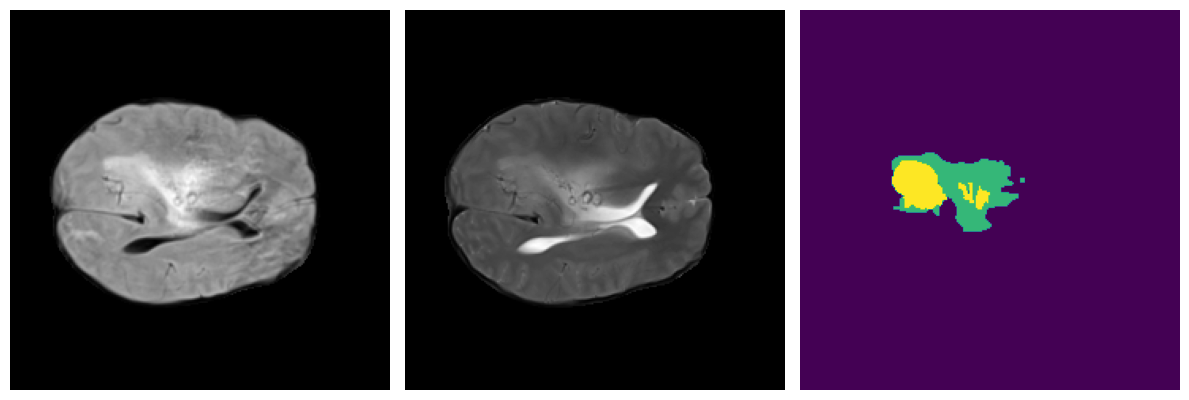

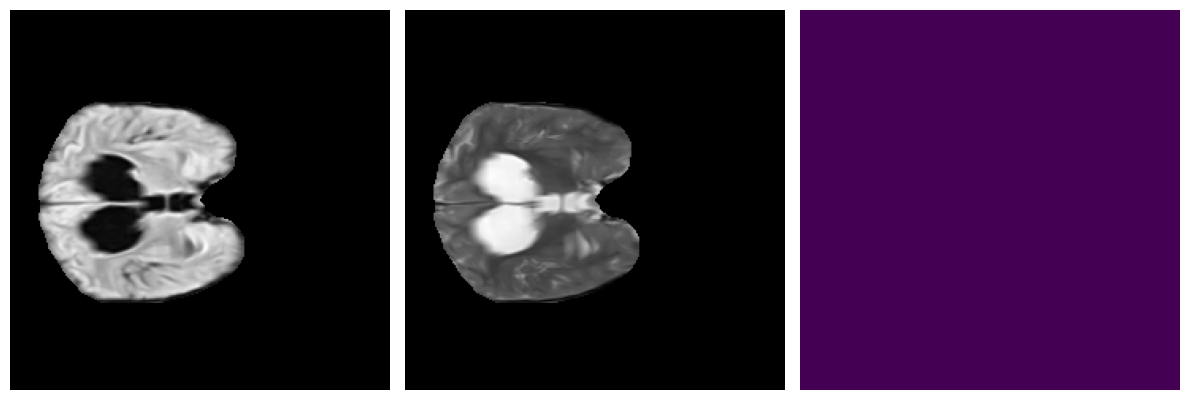

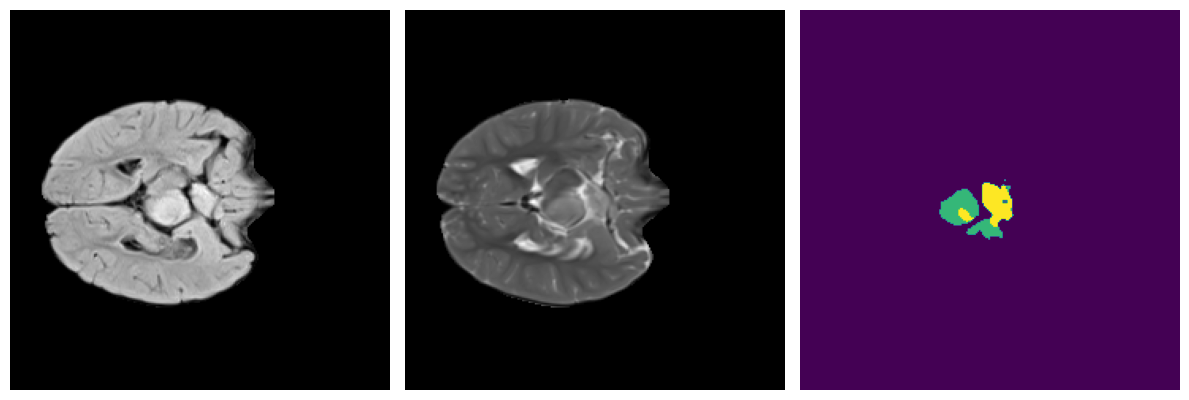

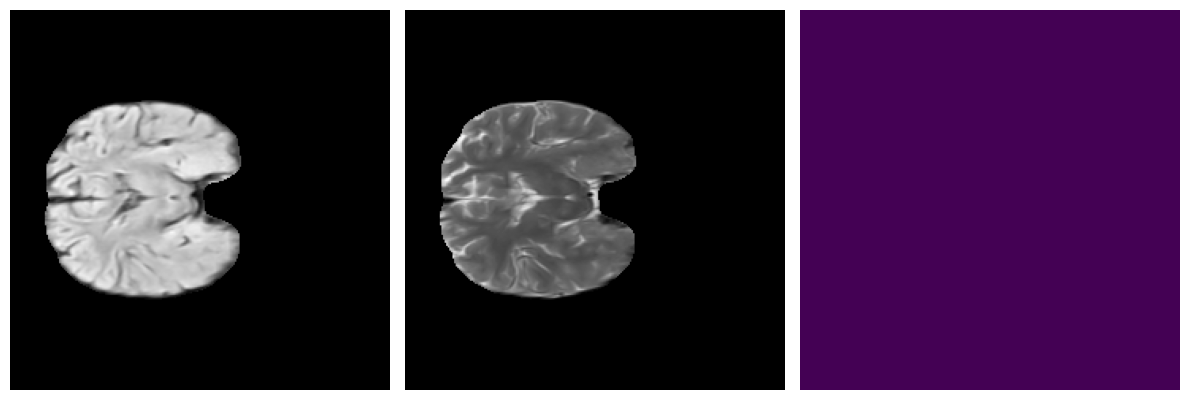

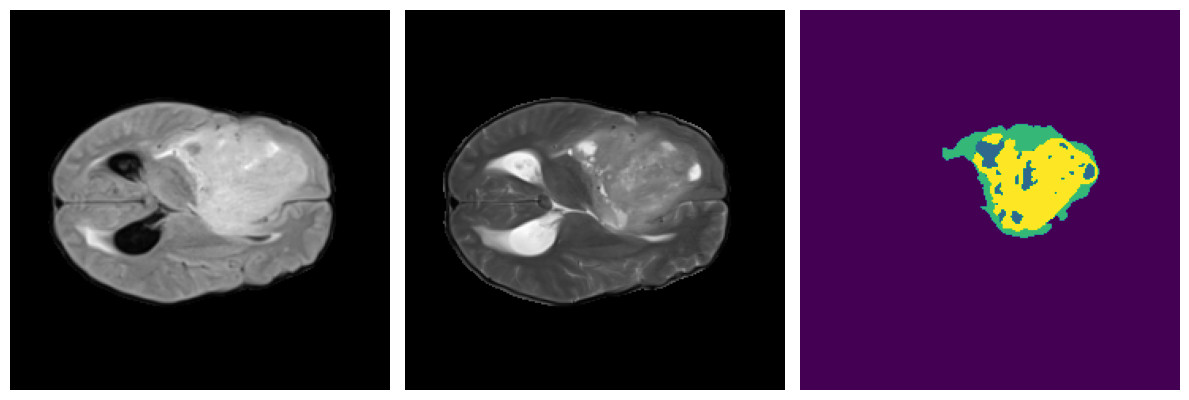

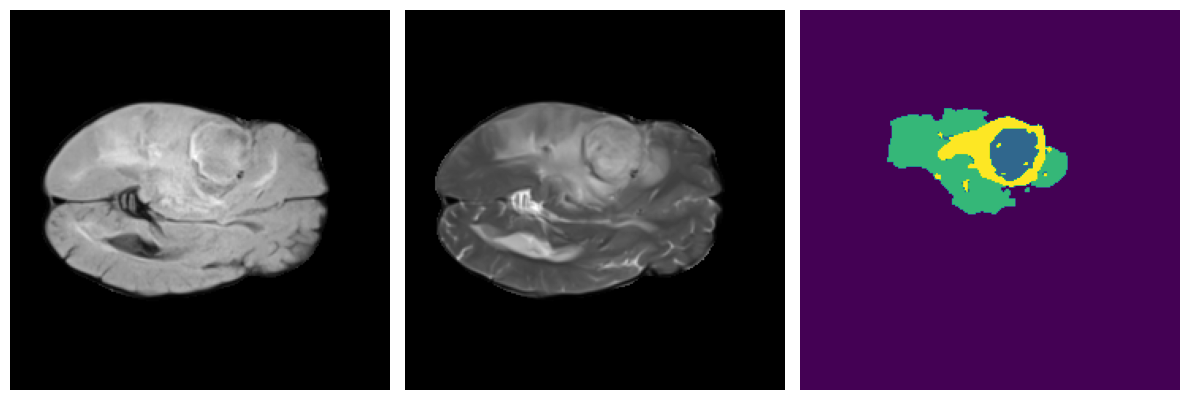

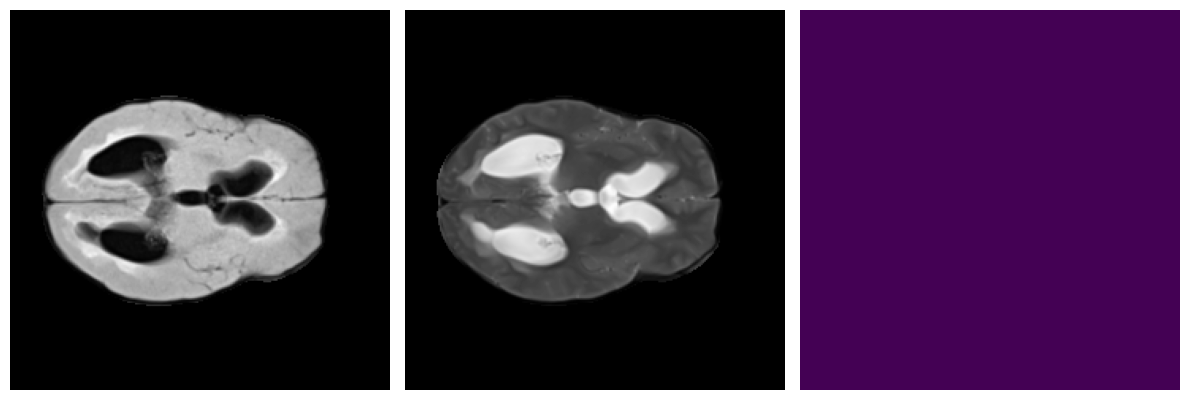

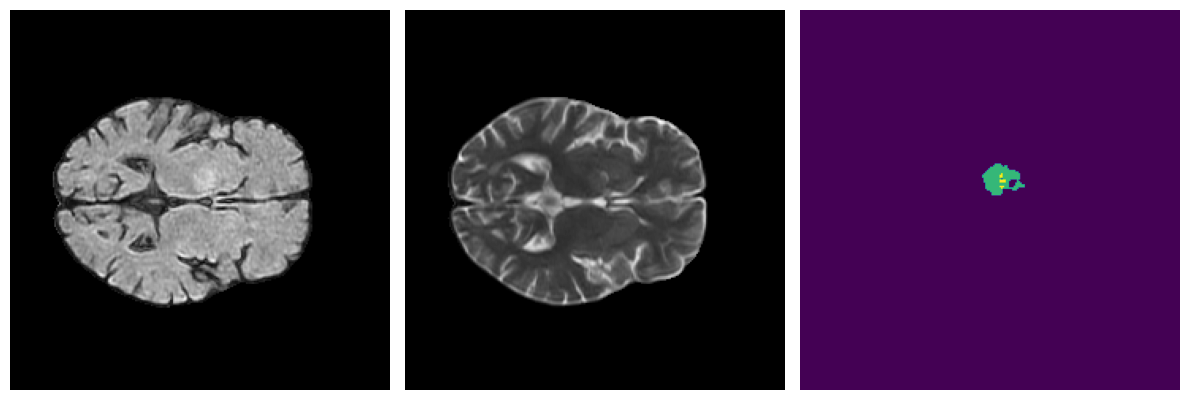

: 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

final_preds = 'D:\\CourseStuff\\SPARK\\BraTS2023\\results\\train_gli\\val_predictions\\train_gli_ftSSA_final_predsf0'

n, z = 15, 75
data = sorted(glob(f"{final_preds}\\*.nii.gz"))
for i in range(n):
    fname = data[i].split("\\")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"D:\\CourseStuff\\SPARK\\BraTS2023\\results\\images\\{fname}.nii.gz").get_fdata().astype(np.float32)
    pred = nib.load(data[i]).get_fdata().astype(np.uint8)[:, :, z]
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()
    plt.savefig(os.path.join(final_preds, f"{fname}.png"),bbox_inches='tight')       
    # plt.show()


# Checkpoint checks

In [ ]:
pth = '/scratch/guest187/Data/train_gli_hack/results_hack_finetune_ssa/checkpoints/f0_finetune/epoch=39-dice=91.38.ckpt'
# pth = '/scratch/guest187/Data/train_all/results/test_fullRunThrough/best_metric_model_fullTest.pth'
checkpoint = torch.load(pth)
keys = checkpoint.keys()

for key in checkpoint.keys():
    print(key)

In [ ]:
state_dict = checkpoint["state_dict"]
print(type(state_dict))

state_dict2 = dict(state_dict)
print(type(state_dict2))


In [ ]:
import pickle
cnfgP = '/scratch/guest187/Data/train_all_nnUNET/train_all_data/results/11_3d/config.pkl'
config = pickle.load(open(cnfgP, "rb"))
print(config)

In [ ]:
patch_size, spacings = config["patch_size"], config["spacings"]
strides, kernels, sizes = [], [], patch_size[:]
while True:
    spacing_ratio = [spacing / min(spacings) for spacing in spacings]
    stride = [
        2 if ratio <= 2 and size >= 2 * 2 else 1 for (ratio, size) in zip(spacing_ratio, sizes)
    ]
    kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
    if all(s == 1 for s in stride):
        break
    sizes = [i / j for i, j in zip(sizes, stride)]
    spacings = [i * j for i, j in zip(spacings, stride)]
    kernels.append(kernel)
    strides.append(stride)
    if len(strides) == 6:
        break
strides.insert(0, len(spacings) * [1])
kernels.append(len(spacings) * [3])

print(strides)
print(kernels)

In [ ]:
sample = nib.load(os.path.join (args.results, "BraTS-SSA-00132-000.nii.gz"))
print(sample.shape)

print(set(np.array(sample.dataobj).flatten()))